In [118]:
import os

import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib
pd.set_option('display.float_format', lambda x: '%.6f' % x)

def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def portfolio_returns(weights, returns):
    '''
    Weights --> Returns
    '''
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    '''
    Weights --> Vol
    '''
    return (weights.T @ covmat @ weights) ** 0.5

def minimise_vol(er, cov):
    '''
    target_return --> W
    '''
    n = er.shape[0]
    init_guess = np.repeat(1 / n, n)
    # bounds = ((0.0, 1.0),) * n

    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = opt.minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP',
                           options={'disp': False},
                           constraints=weights_sum_to_1
                           # bounds=bounds
                           )
    return results.x

def target_return_minimise_vol(target_return, er, cov):
    '''
    target_return --> W
    '''
    n = er.shape[0]
    init_guess = np.repeat(1 / n, n)
    bounds = ((0.0, 1.0),) * n
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - portfolio_returns(weights, er)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = opt.minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP',
                           options={'disp': False},
                           constraints=(weights_sum_to_1, return_is_target),
                           bounds=bounds
                           )
    return results.x

def msr(riskfree_rate, er, cov):
    '''
    RiskFree rate + ER + COV --> W
    '''
    n = er.shape[0]
    init_guess = np.repeat(1 / n, n)
    bounds = ((0.0, 1.0),) * n
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }

    def negative_sharpe_ratio(weights, riskfree_rate, er, cov):
        '''
        Returns the negative of the sharpe ratio, given weights
        '''
        r = portfolio_returns(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate) / vol

    results = opt.minimize(negative_sharpe_ratio,
                       init_guess,
                       args=(riskfree_rate, er, cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds
                       )
    return results.x

def optimal_weights(n_points, er, cov):
    '''
    --> list of weights to run the optimiser on to minimise the vol
    '''
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [target_return_minimise_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov, style=".-", show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False):
    '''
    Plots the n asset efficient frontier
    '''

    #     weights = [np.array([w, 1-w]) for w in np.linspace(0,1,n_points)]
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_returns(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, ylim= [-0.01, 0.01])
    # ax.ylim(0, 1)
    if show_cml:
        ax.set_xlim(left=0)
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_returns(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # Add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color="green", marker="o", linestyle="dashed", markersize=12, linewidth=2)
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_returns(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        ax.plot([vol_gmv], [r_gmv], color="midnightblue", marker="o", markersize=10)
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1 / n, n)
        r_ew = portfolio_returns(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker="o", markersize=10)
    return ax


def var_historic(r, level=5):
    '''
    Returns the Historic VaR at a specified level
    .i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100 - level) percent are above
    '''
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -1 * np.percentile(r, level, method='closest_observation')
    else:
        raise TypeError("Expected r to be Series or DataFrame")


def cvar_historic(r, level=5):
    '''
    Computes the conditional VaR of Series or DataFrame
    '''
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be Series or DataFrame")

### Question 1
Please download the Excel spread sheet "Assignment 1", and then solve questions

Compute the mean return on the portfolio $x=\frac{1}{3}(1, 1, 1)$ consisting of only the risky assets.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.

The file attached below provides excel instructions if needed.

In [119]:
n = 3
wt = np.ones(n) / n
rf = 0.01
rets = np.array([0.06, 0.02, 0.04])
vols = np.array([8.94/100, 4.47/100, 8.94/100])
covmat = np.array([[0.00800,	-0.00200, 0.00400], [-0.00200, 0.00200, -0.00200], [0.00400,-0.00200, 0.00800]])
portfolio_rets = portfolio_returns(weights=wt, returns=rets)
print(f"The portfolio return of equal weight portfolio is {np.round(portfolio_rets*100, 2)}%")


The portfolio return of equal weight portfolio is 4.0%


### Question 2
Compute the volatility of the return on the portfolio $x=\frac{1}{3}(1, 1, 1)$ consisting only of the risky assets (i.e. same portfolio as Question 1).

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.

In [120]:
portfolio_vols = portfolio_vol(weights=wt, covmat=covmat)
print(f"The portfolio vol of equal weight portfolio is {np.round(portfolio_vols* 100, 2)}%")


The portfolio vol of equal weight portfolio is 4.47%


### Question 3
Compute the mean return on the minimum variance portfolio of just the risky assets.

The minimum variance portfolio is defined as the portfolio of risky assets that has the least volatility among all possible portfolios of just the risky assets. This portfolio is the solution to the optimization problem
$min \ \sigma_{x}^2$  $ = $  $min \ x^TVx $
$s.t \ \sum_{i=1}^d \ x_i = 1$  $s.t \ \sum_{i=1}^d \ x_i = 1$


In the data sheet in the workbook Assignment1.xlsx we have set up all the relevant variables - you just have to set up and solve the optimization problem. In particular, you have to set the objective to minimize volatility cell B24 with only the portfolio constraint J20=L20.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.

In [121]:
min_vol_wts = np.round(minimise_vol(er=rets, cov=covmat), 2)
min_vol_port_return = portfolio_returns(weights=min_vol_wts, returns=rets)
min_vol_port = portfolio_vol(weights=min_vol_wts, covmat=covmat)

print(f"The mean return is {np.round(min_vol_port_return* 100, 2)}% on the minimum vol of {np.round(min_vol_port* 100, 2)}%")
min_vol_port

The mean return is 3.04% on the minimum vol of 2.61%


0.026080644163823868

### Question 4
Compute the mean return on the Sharpe optimal portfolio for this market.

Recall that we can compute the Sharpe optimal portfolio by taking only the risky positions and re-scaling them so that the components add up to 1. This procedure can be done by using the functions in following worksheet "Sheet 1". Another way to compute the Sharpe portfolio is to use the formulas of the Sharpe portfolio.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67

### Question 5
Compute the volatility of the Sharpe optimal portfolio for this market.

Recall that we can compute the Sharpe optimal portfolio by taking the risky positions corresponding to any risk aversion parameter and re-scaling them so that the components add up to 1.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.




In [122]:
msr_port_wt = np.round(msr(riskfree_rate=rf, er=rets, cov=covmat), 3)
msr_port_return = portfolio_returns(weights=msr_port_wt, returns=rets)
msr_port_vol = portfolio_vol(weights=msr_port_wt, covmat=covmat)
print(f"The MSR mean return is {np.round(msr_port_return* 100, 2)}% on the minimum vol of {np.round(msr_port_vol* 100, 2)}%")
msr_port_wt

The MSR mean return is 3.42% on the minimum vol of 2.84%


array([0.292, 0.583, 0.125])

### Question 6
Using the results in the previous question, compute the slope of the capital market line.

Submission Guideline: Give your answer rounded to 2 decimal places. For example, if you compute the answer to be 2.67123, submit 2.67.

### Notes
The portfolio $s^*$ is the Maximum Sharpe Ration portfolio whose angle $\theta$ is maximum hence $tan(\theta) = \frac{MSR\ Expected\ Excess\ Return}{MSR\ Volatility}$


In [123]:
msr_excess_return = msr_port_return - rf
theta_angle = msr_excess_return/msr_port_vol
print(f"The slope of CML is {np.round(theta_angle, 2)} ")

The slope of CML is 0.85 


### Question 7

Suppose the volatility of an efficient investment opportunity is $\sigma = 5\%$ What is the return on this opportunity?

Recall that the mean return and volatility of all efficient investment opportunities must lie on the capital market line.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you answer the return to be 2.67%, submit 2.67.

In [124]:
given_vol = 5/100
return_given_vol = theta_angle * given_vol
print(f"The Efficient Return given {np.round(given_vol* 100, 2)}% Vol is {np.round((return_given_vol + rf)*100, 2)}%")

The Efficient Return given 5.0% Vol is 5.26%


In [125]:
script_dr = os.getcwd()
df = pd.read_excel(os.path.abspath(os.path.join(script_dr, '..', 'Data', 'FERM_3_Assignment_1.xlsx')), sheet_name='Daily_Returns_Q1_Q2')
df

,date,IBM,GE,LLY,F,BAC,KR,ITUB,GG,SIRI,...,T,ECA,ABEV,CVS,MRVL,CSCO,MO,BMY,WFC,HBAN
0,2016-01-04,-0.000736,0.000976,0.014852,-0.018058,0.000000,0.022343,0.008006,-0.023029,-0.010178,...,0.006963,0.026925,0.013954,0.002899,-0.032335,-0.004554,0.020011,0.019501,-0.000378,0.001867
1,2016-01-05,-0.005018,-0.016069,-0.006321,-0.045479,-0.021533,-0.000951,-0.008006,0.018804,-0.005128,...,-0.015441,-0.062643,-0.011614,-0.012273,-0.056744,-0.010708,0.010534,-0.017713,-0.019281,-0.015985
2,2016-01-06,-0.017237,-0.043235,-0.026306,-0.031773,-0.036736,-0.023581,-0.031023,0.074229,-0.012937,...,-0.016280,-0.049700,-0.040530,-0.014546,0.009889,-0.023338,-0.017561,-0.028090,-0.028942,-0.030801
3,2016-01-07,-0.009301,-0.018113,-0.001967,-0.012678,-0.019545,-0.006596,0.000000,-0.018247,-0.007843,...,0.000895,0.037504,0.016888,-0.006605,0.011009,-0.025106,0.001719,-0.025754,-0.016807,-0.017752
4,2016-01-08,0.012082,0.004559,-0.012135,0.018175,0.007211,0.011696,-0.001660,-0.055982,0.002621,...,0.012150,-0.035384,-0.016888,0.014431,0.012092,0.019581,0.020731,-0.010268,0.010637,0.004963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2017-12-21,0.006579,0.001716,-0.006328,-0.003967,0.002010,0.025091,-0.006211,0.007981,0.018798,...,0.001542,0.004773,0.001596,-0.016616,-0.001816,0.000519,0.002776,-0.008819,-0.000974,-0.004051
498,2017-12-22,0.002162,-0.004008,-0.000941,0.001589,-0.003352,-0.016057,0.004662,0.011067,0.009268,...,0.003077,0.039678,0.012678,0.003671,-0.007754,-0.001817,-0.000832,0.004909,-0.006847,-0.010201
499,2017-12-26,0.001961,-0.002873,0.001763,-0.007968,-0.001680,-0.003243,-0.006221,-0.003150,-0.005550,...,-0.004362,0.001524,0.003145,-0.012565,0.009569,0.002077,0.004844,0.006833,-0.002949,-0.002738
500,2017-12-27,0.005925,-0.001151,-0.001058,0.006380,0.002352,-0.002168,0.008544,0.002363,-0.001857,...,0.007429,0.014367,0.007819,0.003978,-0.007283,0.000778,-0.016145,0.001458,0.005726,0.010228


### Question 1
A file of the stocks daily returns (Calculated as $\frac{P_{i+1} - P_i}{P_i}$) from January 4th 2016- December 28th 2017 is provided below. Please download this file to answer the questions.

There are 23 stocks' daily returns from January 4th, 2016 to December 28th, 2017 from Yahoo Finance. Suppose these 23 stocks are the only risky assets available in the market. Please compute the mean daily returns of each stock, and the covariance matrix of those stocks' returns. Please enter the average daily return of Stock 'GE' from from January, 4th 2016 to December 28th, 2017. (Round to the fourth decimal place.)

In [126]:
ticker = 'GE'
df[ticker].mean()
print(f"The Average daily return of {ticker} is {np.round(df[ticker].mean(), 4)}")

The Average daily return of GE is -0.0011


### Question 2
Continued from Question 1

Please enter the covariance between daily returns of IBM and GE from from January, 4th 2016 to December 28th, 2017. (Round to the sixth decimal place.)


In [127]:
tics = ['IBM', 'GE']
cov = sample_cov(df[tics])[tics[0]][tics[1]]
print(f"The covariance between {tics[0]} and {tics[1]} is {np.round(cov, 6)}")

The covariance between IBM and GE is 4.7e-05


### Question 3
Continued from Question 2

Suppose we want to minimize the risk of the portfolio with the constraint that average daily return should be greater than or equal to 0.05%. i.e. :
$minimise\ x^TVx$
$s.t. \mu^Tx\ > 0.0005$
$1^Tx = 1$
where $\mu$ is the daily return vector of stocks, x is weight vector of stocks in the portfolio, and V is the covariance matrix of stocks daily return
What is the optimal value?
Let $x_1$ be your optimal portfolio in this problem

### Question 4
Continued from Question 3

What is the expected return of the portfolio $x_1$? (Round your answer to the fourth decimal place.)

Think about if it is greater than 0.05%, smaller than 0.05% or equal to 0.05%.


In [128]:
target_return_x1 = 0.0005
cov = sample_cov(df)
returns = df.mean()
weights1 = target_return_minimise_vol(target_return=target_return_x1, er=returns, cov=cov)
portfolio_ret1 = portfolio_returns(weights=weights1, returns=returns)
portfolio_vol1 = portfolio_vol(weights=weights1, covmat=cov)
x1= portfolio_vol1**2

print(f"The optimal portfolio variance is {x1} with target return of {target_return_x1} is {np.round(portfolio_ret1, 4)}")

/var/folders/gw/hq2jnpl90jjfpr7ymdkq6k580000gn/T/ipykernel_1766/2823640740.py:13: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return r.cov()
/var/folders/gw/hq2jnpl90jjfpr7ymdkq6k580000gn/T/ipykernel_1766/661419433.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  returns = df.mean()


The optimal portfolio variance is 3.5363473583153514e-05 with target return of 0.0005 is 0.0005


### Question 5
Continued from Question 4

Suppose we now want to change the previous constraint so that the average daily return should be greater than or equal to 0.08%.

What is the new optimal value of the problem? (Round your solution to the sixth decimal place.) Let $x_2$ be your optimal portfolio in this problem.


In [129]:
target_return_x2 = 0.0008
weights2 = target_return_minimise_vol(target_return=target_return_x2, er=returns, cov=cov)
portfolio_ret2 = portfolio_returns(weights=weights2, returns=returns)
portfolio_vol2 = portfolio_vol(weights=weights2, covmat=cov)
x2 = portfolio_vol2**2

print(f"The optimal portfolio variance is {np.round(x2, 6)} with target return of {target_return_x2} is {np.round(portfolio_ret2, 4)}")

The optimal portfolio variance is 4.3e-05 with target return of 0.0008 is 0.0008


### Question 6
Suppose we now want to change the previous constraint so that the average daily return should be greater than or equal to 0.1%.

Solve for the optimal solution $x_3$ by solving the mean variance problem.

Compute $z = \phi x_1 + (1-\phi) x_2$ where $\phi = \frac{0.08\% - 0.1\%}{0.08\% - 0.05\%}$

Compare $z$ and $x_3$, test two fund theorem:

In [130]:
target_return_x3 = 0.001
phi = (target_return_x2 - target_return_x3)/(target_return_x2 - target_return_x1)
z = phi * x1 + (1-phi)*x2
weights3 = target_return_minimise_vol(target_return=target_return_x3, er=returns, cov=cov)
portfolio_ret3 = portfolio_returns(weights=weights3, returns=returns)
portfolio_vol3 = portfolio_vol(weights=weights3, covmat=cov)
x3 = portfolio_vol3**2
diff = z - x3
verdict ='Same' if abs(diff) > 0.0000001 else 'Not Same'
print(f"The z and x3 is {verdict}")

The z and x3 is Same


### Question 9
Assume the risk free rate of daily return $r_f = 0.01\%$. We want to maximize the Sharpe ratio problem:
$minimise  \frac{(\mu- r_f)^T x}{sqrt{(x^TVx)}}$
$s.t. 1^Tx = 1$
The problem is now equivalent to maximize the return of unit risk, which is also called the market price of risk.  We can rewrite maximization of the Sharpe ratio as minimizing the risk of unit return.
$minimise x^TVx$
$s.t.(\mu - r_f)^Tx = 1$
Now the $x$ from the optimal solution is no longer the weight vector of our portfolio.

So our sharp portfolio should be
$x_{sharpe}^* = \frac{x}{1^T x}$

Compute the Sharpe ratio for these stocks and round your answer to the  third decimal place.


In [131]:
risk_free = 0.01/100
msr_port_wt1 = np.round(msr(riskfree_rate=risk_free, er=returns, cov=cov), 3)
msr_port_return1 = portfolio_returns(weights=msr_port_wt1, returns=returns)
msr_port_vol1 = portfolio_vol(weights=msr_port_wt1, covmat=cov)
print(f"The MSR mean return is {np.round(msr_port_return* 100, 2)}% on the minimum vol of {np.round(msr_port_vol* 100, 2)}%")
# print(msr_port_return1, msr_port_vol1)

sharpe_ratio = (msr_port_return1 - risk_free)/msr_port_vol1
print(f"The sharpe ratio is the portfolio is {np.round(sharpe_ratio, 3)}")


The MSR mean return is 3.42% on the minimum vol of 2.84%
The sharpe ratio is the portfolio is 0.149


### When Market Performs Badly

In this part, the market has a very low yearly return. The Capital Asset Pricing Model will give you a negative Sharpe Ratio and the Capital Market Line will have a negative slope.  In this situation, how will you interpret the results from CAPM?  Will you still invest in the Sharpe optimal portfolio?

We are going to explore the limitations of simple Mean-Variance optimization models with a use case from stocks data from January 1st 2018 to January 1st 2019. You will discuss how to approach more complicated scenarios in the real world.

Think about the following questions:

Compute average daily returns and covariance matrix for those risky assets.

Get the efficient frontier of the market.

Compute Sharpe optimal portfolio and draw the Capital Market Line.

Compare the risk free rate and the return of Sharpe optimal portfolio.

You will find that the Sharpe optimal portfolio has a lower return but a higher risk than the risk free asset. Does CAPM show you an arbitrage opportunity?

Is it reasonable to use average daily return and sample covariance to be the parameters of CAPM?  How will you fine-tune the parameters?

In [132]:
ndf = pd.read_csv(os.path.abspath(os.path.join(script_dr, '..', 'Data', 'stock_returns_2018.csv')))
r_2018 = ndf.mean()
cov_2018 = sample_cov(ndf)
r_2018

/var/folders/gw/hq2jnpl90jjfpr7ymdkq6k580000gn/T/ipykernel_1766/1539634806.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  r_2018 = ndf.mean()
/var/folders/gw/hq2jnpl90jjfpr7ymdkq6k580000gn/T/ipykernel_1766/2823640740.py:13: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return r.cov()


IBM    -0.001221
GE     -0.003460
LLY     0.001249
F      -0.002015
BAC    -0.000774
KR     -0.000115
ITUB    0.000053
GG     -0.001197
SIRI    0.000367
ACB    -0.002591
VALE    0.000129
PFE     0.000722
CTL    -0.000556
T      -0.001202
ECA    -0.003458
ABEV   -0.002090
CVS    -0.000461
MRVL   -0.001263
CSCO    0.000436
MO     -0.001437
BMY    -0.000660
WFC    -0.001128
HBAN   -0.000811
dtype: float64

In [133]:
risk_free = 0.01/100
msr_port_wt2018 = np.round(msr(riskfree_rate=risk_free, er=r_2018, cov=cov_2018), 3)
msr_port_return2018 = portfolio_returns(weights=msr_port_wt2018, returns=returns)
msr_port_vol2018 = portfolio_vol(weights=msr_port_wt2018, covmat=cov_2018)
print(f"The MSR mean return is {np.round(msr_port_return2018* 100, 2)}% on the minimum vol of {np.round(msr_port_vol2018* 100, 2)}%")
# print(msr_port_return1, msr_port_vol1)

sharpe_ratio = (msr_port_return2018 - risk_free)/msr_port_vol2018
print(f"The sharpe ratio is the portfolio is {np.round(sharpe_ratio, 3)}")
msr_port_wt2018

The MSR mean return is 0.0% on the minimum vol of 1.4%
The sharpe ratio is the portfolio is -0.004


array([0.   , 0.   , 0.981, 0.   , 0.   , 0.   , 0.   , 0.   , 0.019,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ])

<Axes: xlabel='Volatility'>

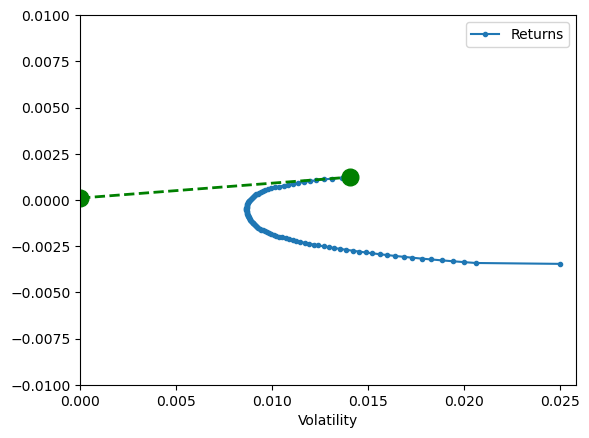

In [134]:
plot_ef(n_points=100, er=r_2018, cov=cov_2018, show_cml=True, riskfree_rate=risk_free)

# Practical Issues with Mean Variance Portfolio Problem Set
### Problem 1
Please download the following file and use the excel spread sheet "Monthly Returns" to solve the following questions. (The covariance and expected returns are calculated from the simulated data.)
Compute an estimated efficient portfolio with 5% volatility. What is the estimated return on this portfolio? (Hint: you can use the risk free asset to construct the portfolio.)

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.


### Problem 2
Compute the true expected return (realized return) of the portfolio that you computed in Problem 1.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.

In [135]:
q1_returns = np.array([-0.5186,	4.7057,	-0.6986])
q1_covmat = np.array([[0.0056,-0.0020,0.0037], [-0.0020,0.0022,-0.0022], [0.0037,-0.0022,0.0074]])
risk_free = 1
q1_msr_port_wt = np.round(msr(riskfree_rate=risk_free, er=q1_returns, cov=q1_covmat), 3)
q1_msr_port_return = portfolio_returns(weights=q1_msr_port_wt, returns=q1_returns)
q1_msr_port_vol = portfolio_vol(weights=q1_msr_port_wt, covmat=q1_covmat) *100
q1_msr_excess_return = q1_msr_port_return - risk_free
theta_angle = q1_msr_excess_return/q1_msr_port_vol
# print(f"The slope of CML is {np.round(theta_angle, 2)} ")
given_vol = 5/100
return_given_vol = theta_angle * given_vol
print(f"The Efficient Return given {np.round(given_vol* 100, 2)}% Vol is {np.round((return_given_vol )*100 + risk_free, 2)}%")
print(f"The MSR Portfolio Return is {np.round(q1_msr_port_return, 2)}%")

The Efficient Return given 5.0% Vol is 5.32%
The MSR Portfolio Return is 3.56%


### Problem 3
In the "Value-at-Risk" worksheet, we list the simulated monthly returns again. From these returns, we compute the monthly rate of loss on an equally weighted portfolio of only the risky assets in column E. Use this data to estimate the Value-at-Risk at the 90% probability level.

The formula to compute Value-at-Risk is on page 6 of the slides for the Beyond Variance module.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.


In [136]:
# Load the Assigment Data

adf = pd.read_excel(os.path.abspath(os.path.join(script_dr, '..', 'Data', 'Assignment2.xlsx')), sheet_name='Value_at_risk')
adf = adf[['Asset 1', 'Asset 2', 'Asset 3', 'Equally weighted loss']]
var_90 = var_historic(adf['Equally weighted loss'], level=90)
print(f"The Var at 90% probability is {np.round(var_90, 2)}")
print(var_90)


print(np.percentile(adf['Equally weighted loss'], 90, method='closest_observation'))
adf['Equally weighted loss'].sort_values()

The Var at 90% probability is -1.29
-1.2922666666666667
1.2922666666666667


/Users/deepakchoudhary/anaconda3/envs/MortgageModelling/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


15   -2.888767
25   -2.456500
45   -2.056867
6    -1.909200
33   -1.881900
55   -1.491567
1    -1.356500
10   -1.304533
54   -1.263933
34   -1.139733
0    -1.116800
3    -1.039633
13   -0.968533
18   -0.951133
56   -0.939533
46   -0.869867
20   -0.861900
59   -0.736000
9    -0.667767
51   -0.607667
48   -0.511400
47   -0.455067
43   -0.392433
31   -0.304533
58   -0.275867
53   -0.275567
38   -0.272167
29   -0.256367
8    -0.233233
22   -0.205333
27   -0.194233
36   -0.095967
26   -0.065600
49   -0.041167
39   -0.021833
5    -0.004967
21    0.068467
19    0.081033
24    0.179533
50    0.251467
28    0.347100
32    0.461933
4     0.566233
16    0.602200
40    0.814033
11    0.822867
44    0.884567
23    0.956500
12    0.961633
37    1.044033
14    1.063100
7     1.103900
17    1.120433
30    1.292267
2     1.375367
52    1.880733
41    1.919133
35    1.987667
42    2.145000
57    2.370733
Name: Equally weighted loss, dtype: float64

### Problem 4
In the "Value-at-Risk" worksheet, we list the simulated monthly returns again. From these returns, we compute the monthly rate of loss on an equally weighted portfolio of only the risky assets in column E. Use this data to estimate the Conditional Value-at-Risk at the 90% probability level.

The formula to compute Value-at-Risk is on page 6 of the slides for the Beyond Variance module.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.

In [139]:
cvar_90 = cvar_historic(adf['Equally weighted loss'], level=10)
print(f"The C Var at 90% probability is {np.round(cvar_90, 2)}")

The C Var at 90% probabality is 2.11


### Problem 5
Consider a portfolio manager who has been successful in 12 years out of 15. Compute the probability of the manager having a track record as good as or better than this if he had no skill (by no skill, we mean the managers have half of the chance to outperform the market, $p=0.5$). You may assume that success or failure in any year is independent of success or failure in any other year.

Submission Guideline: Give your answer to 4 decimal places. For example, if you compute the probability to be 0.12345, then you should submit an answer of 0.1235


In [148]:
from scipy.stats import binom
p = 0.5
n = 15
x = 11

success = 1-binom.cdf(k=x, n=n, p=p)
print(f"The Track record of {x+1} successful year of {n} years are {np.round(success, 4)}")



The Track record of 12 successful year of 15 years are 0.0176


### Problem 6
Suppose now there are $M=100$ fund managers, each of whom have 15-year track records. Suppose the best manager outperformed in 14 of the 15 years. Compute the probability that the best of the managers had a track record as good as or better than this (outperform the market 14 times out of 15) if all of them had no skill (by no skill, we mean the managers have half of the chance to outperform the market, $p=0.5$). You may assume that success or failure in any year is independent of success or failure in any other year and that the managers' performances are independent of each other.

Submission Guideline: Give your answer to 4 decimal places. For example, if you compute the probability to be 0.12345, then you should submit an answer of 0.1235.

In [154]:
M = 100
y = 13

combined_success = 1 - binom.cdf(k=y, n=n, p=p)**M
print(f"The Track record of {y+1} successful year of {n} years for {M} managers are {np.round(combined_success, 4)}")

The Track record of 14 successful year of 15 years for 100 managers are 0.0477


### Problem 7
Consider a version of the Monty Hall problem where there are 4 doors. There are goats behind 2 of the doors and valuable prizes behind the other two doors. The game is played as follows:

1. You first choose a door.

2. Before your chosen door is opened Monty Hall opens one of the other 3 doors and reveals a goat behind that door.

3. He now gives you the opportunity to change your mind and select another door.

4. Your chosen door is now opened and your prize is revealed.

If you behave optimally, what is the probability that you will win one of the valuable prizes?

Submission Guideline: Give your answer to 2 decimal places. For example, if you compute the probability to be 0.4532, then you should submit an answer of 0.45.

In [155]:
doors = [1, 2, 3, 4]
prize = 2
goat = 2
p_of_prize = prize / (prize + goat)
p_of_goat = goat / (prize + goat)

p_of_prize*p_of_goat + p_of_goat


0.75